In [1]:
%pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sys import platform
import subprocess

# if the platform is Mac OS X, install the nightly build of PyTorch
if platform == "darwin":
  print("Installing nightly build of PyTorch for Mac OS X")
  # %pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
  subprocess.run(["pip", "install", "--pre", "torch", "torchvision", "torchaudio", "--extra-index-url", "https://download.pytorch.org/whl/nightly/cpu"])
else:
  print("Installing PyTorch for Linux")
  # %pip install torch torchvision torchaudio
  subprocess.run(["pip", "install", "torch", "torchvision", "torchaudio"])


Installing PyTorch for Linux


In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
import numpy as np
from IPython.display import Image
from matplotlib import image, pyplot
import random
%matplotlib inline

In [4]:
# Use GPU if it exists - for faster execution
# Device selection for PyTorch
device = torch.device("cpu")

# Device selection for PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')

device

Using GPU


device(type='cuda', index=0)

In [5]:
# Download the dataset and unzip - RUN ONLY ONCE!
# zip_file_url = "https://austons-ml-bucket.s3.fr-par.scw.cloud/cats_and_dogs_filtered.zip"
# import requests, zipfile, io

# r = requests.get(zip_file_url)
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall("./data/")

In [6]:
# Import all the images into the memory
# Lets check how many files are in the dataset
import os
from typing import List
from matplotlib import image

train_dataset_path = "./data/cats_and_dogs_filtered/train/"
validation_dataset_path = "./data/cats_and_dogs_filtered/validation/"


def getAllFiles(categories: List[str], data_root: str, includeFileData=False) -> dict:
  filesByCategory = {}

  for category in categories:
    count = 0
    full_path = train_dataset_path + category

    for file_name in os.listdir(full_path): 
      count+=1
      file_path = full_path + "/" + file_name
      file = {
        "file_name": file_name,
        "file_path": file_path,
        "data": None
      }
      
      if includeFileData:
        file["data"] = image.imread(file_path)
        
      if category in filesByCategory.keys():
        filesByCategory[category].append(file)
      else:
        filesByCategory[category] = [file]

    print(f"Total {category} images: {count}")
  return filesByCategory
    
categories = ["cats", "dogs"]
filesByCategory = getAllFiles(categories, train_dataset_path)


Total cats images: 1000
Total dogs images: 1000


------cats!----
uint8
(262, 349, 3)


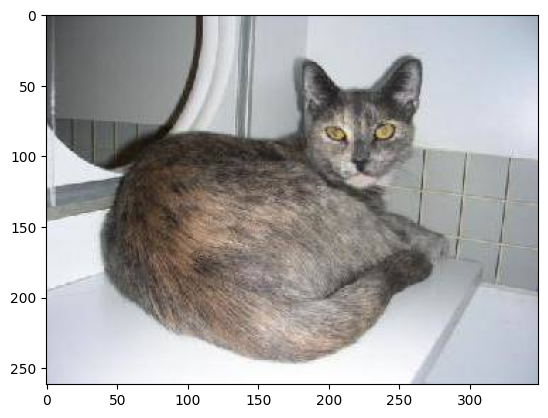

------dogs!----
uint8
(480, 432, 3)


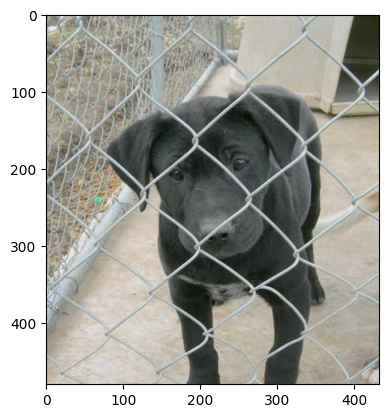

In [7]:
for category in filesByCategory:
  print(f"------{category}!----")
  file_path = filesByCategory[category][0]["file_path"]
  my_image = image.imread(file_path)
  print(my_image.dtype)
  print(my_image.shape)
  pyplot.imshow(my_image)
  pyplot.show()
  

In [8]:
# Create X Train and y Train
trainingfilesByCategory = getAllFiles(categories, train_dataset_path, False)
X_train = []
y_train = []

for i in range(0, len(categories)):
  category = categories[i]
  for file in trainingfilesByCategory[category]:
    X_train.append(file["file_path"])
    y_train.append(category)
    
# Create X Validation and y Validation
validationfilesByCategory = getAllFiles(categories, validation_dataset_path, False)
X_validation = []
y_validation = []

for i in range(0, len(categories)):
  category = categories[i]
  for file in trainingfilesByCategory[category]:
    X_validation.append(file["file_path"])
    y_validation.append(category)


Total cats images: 1000
Total dogs images: 1000
Total cats images: 1000
Total dogs images: 1000


In [9]:
import os
import pandas as pd
from torchvision.io import read_image

torch.manual_seed(17)

class CustomImageDataset(Dataset):
    def __init__(self, img_labels, img_paths, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_paths = img_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [10]:
batch_size = 64
image_size = 224
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((image_size, image_size)),
    # T.RandomResizedCrop(image_size),
    # T.RandomHorizontalFlip(),
    # T.Grayscale(),
    T.ToTensor()])

def create_target_tranform(labels):
    # Create a labelMap
    labels_set = set(labels)
    labels_map = {}
    labels_id_map = {}
    for id,val in enumerate(labels_set):
        labels_map[val] = id
        labels_id_map[id] = val
    def encoder(label):
        return labels_map[label]
    def decoder(label_encoded):
        return labels_id_map[label_encoded]

    return encoder, decoder
    
category_encoder, category_decoder = create_target_tranform(y_train)    

train_dataset = CustomImageDataset(img_labels=y_train, img_paths=X_train, transform=transform, target_transform=category_encoder)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)

validation_dataset = CustomImageDataset(img_labels=y_validation, img_paths=X_validation, transform=transform, target_transform=category_encoder)
validation_dl = DataLoader(validation_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)


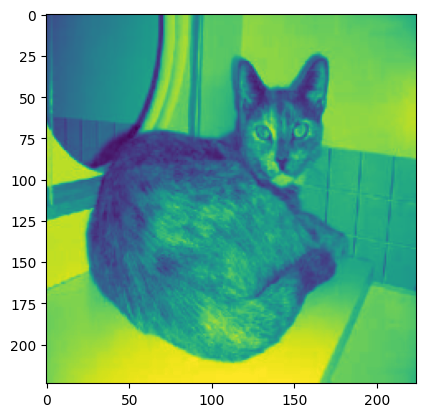

In [11]:
tensor = train_dl.dataset[0][0]
np_arr = tensor.cpu().detach().numpy()
# plt.imshow(np_arr[0], cmap='gray')
pyplot.imshow(np_arr[0])
pyplot.show()

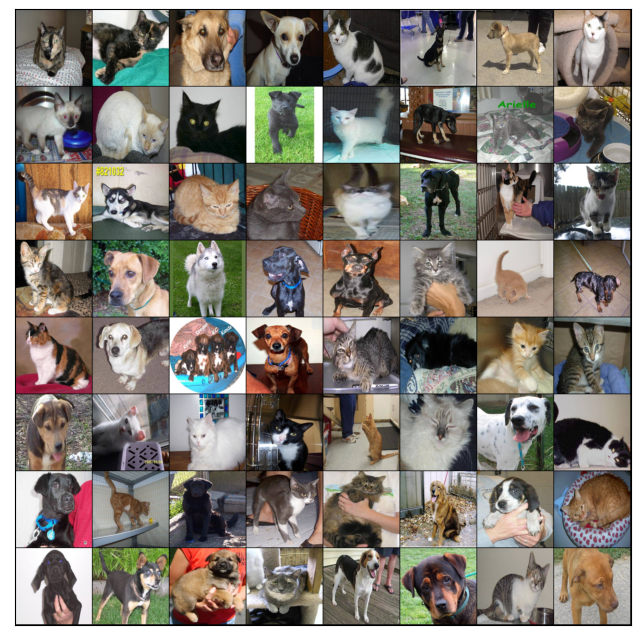

In [12]:
def show_images(images, nmax=64):
    fig, ax = pyplot.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for batch in dl:
        images, labels = batch
        show_images(images, nmax)
        break

show_batch(train_dl)

In [13]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [14]:
# Craete a neural network from pytorch
# https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [15]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [16]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [21]:
import time

epochs = 2

train_acc_epochs = []
train_loss_epochs = []
test_acc_epochs = []
test_loss_epochs = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    t0 = time.time()
    
    for data, label in train_dl:
        
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_dl)
        epoch_loss += loss/len(train_dl)
        
    t1 = time.time()
        
    print('Epoch : {}, train accuracy : {}, train loss : {}, time taken : {}'.format(epoch+1, epoch_accuracy, epoch_loss, t1 - t0))
    train_acc_epochs.append(epoch_accuracy.item())
    train_loss_epochs.append(epoch_loss.item())
    
    with torch.no_grad():
        t0 = time.time()
        
        epoch_val_accuracy=0
        epoch_val_loss =0

        for data, label in validation_dl:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            # Since optimizer isnt run here, we are not trainin the model, we will just check
            # the accuracy!
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(validation_dl)
            epoch_val_loss += val_loss/ len(validation_dl)
            
        t1 = time.time()
        print('Epoch : {}, val_accuracy : {}, val_loss : {}, time taken : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss, t1 - t0))
        test_acc_epochs.append(epoch_val_accuracy.item())
        test_loss_epochs.append(epoch_val_loss.item())

Epoch : 1, train accuracy : 0.7890625, train loss : 0.4720192849636078, time taken : 5.1870973110198975
Epoch : 1, val_accuracy : 0.84521484375, val_loss : 0.3886761963367462, time taken : 5.078361988067627
Epoch : 2, train accuracy : 0.830078125, train loss : 0.3962547481060028, time taken : 5.20198130607605
Epoch : 2, val_accuracy : 0.896484375, val_loss : 0.3032742440700531, time taken : 5.127959251403809


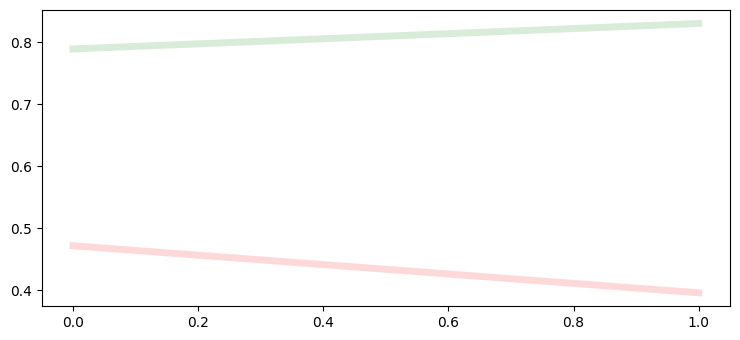

In [29]:
# Print a graph of the values
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
overlapping = 0.150
line1 = plt.plot(train_acc_epochs, c='green', alpha=overlapping, lw=5)
line2 = plt.plot(train_loss_epochs, c='red', alpha=overlapping,
lw=5)
plt.show()

In [ ]:
import time


def validateModel(model, dataloader, criterion, epoch):
    with torch.no_grad():
        t0 = time.time()
        
        epoch_val_accuracy=0
        epoch_val_loss=0

        for data, label in dataloader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            # Since optimizer isnt run here, we are not trainin the model, we will just check
            # the accuracy!
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(dataloader)
            epoch_val_loss += val_loss/ len(dataloader)
            
        t1 = time.time()
        print('Epoch : {}, val_accuracy : {}, val_loss : {}, time taken : {}'.format(epoch+1, epoch_val_accuracy, epoch_val_loss, t1 - t0))

def trainModel(model, dataloader, optimizer, criterion, epoch):
    
    t0 = time.time()
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_dl:
        data = data.to(device)
        label = label.to(device)
        
        # Get the output and loss
        output = model(data)
        loss = criterion(output, label)
        
        # Optimize the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Check for Accuracy
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(dataloader)
        epoch_loss += loss/len(dataloader)
    
    t1 = time.time()
    
    print('Epoch : {}, train accuracy : {}, train loss : {}, time taken : {}'.format(epoch+1, epoch_accuracy, epoch_loss, t1 - t0))

        
# ----- EPOCH Training----
epochs = 10

for epoch in range(epochs):
    
    trainModel(model=model, dataloader=train_dl, criterion=criterion, optimizer=optimizer, epoch=epoch)        

    validateModel(model=model, dataloader=validation_dl, criterion=criterion, epoch=epoch)
    
